## Logistic Regression using Gradient Descent

We've learned a lot of theories in the previous notebook, but just like what Richard Feynman used to say, "What I cannot create, I do not understand", so let's try to implement our own Logistic Regression algorithm from scratch. We're now going to predict whether a student is admitted or not based on their exam scores.

First, let's load up the exam data

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize

df = pd.read_csv('Data/examdata.csv', header = None)
df.rename(columns = {0: 'exam1', 1: 'exam2', 2: 'y'}, inplace = True)
df.head()

,exam1,exam2,y
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


It's a good habit to visualize our data in a scatterplot before proceeding

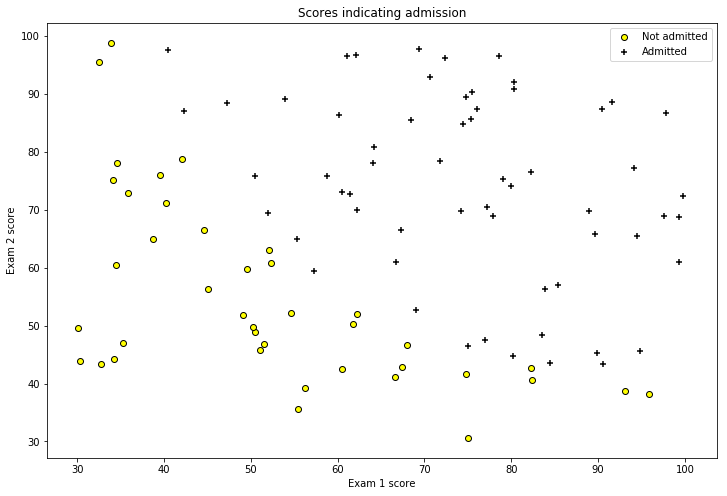

In [2]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(df[df['y'] == 0]['exam1'], df[df['y'] == 0]['exam2'],
            label = 'Not admitted', color = 'yellow', edgecolor = 'black')
plt.scatter(df[df['y'] == 1]['exam1'], df[df['y'] == 1]['exam2'],
            label = 'Admitted', marker = '+', color = 'black')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(loc = 'upper right')
plt.title('Scores indicating admission')
plt.show()

Hmm, looks pretty separable

## Implementation
Now let's implement our Logistic Regression

In [3]:
class LogisticRegression:
    """Performs Logistic Regression using Batch Gradient
    Descent."""
    def __init__(self, X, y, epoch = 5000):
        """Initialise variables.
        
        Parameters
        ----------
        y : numpy array like, output / dependent variable
        X : numpy array like, input / independent variables
        epoch : Number of maximum iterations to perform
            gradient descent
        """
        self.X = self._hstack_one(X)
        self.y = y
        self.epoch = epoch
        self.thetas = np.zeros(self.X.shape[1])
        self.n_rows = self.X.shape[0]
        print("Cost before fitting: %.4f" % self.cost())
        
    @staticmethod
    def _hstack_one(input_matrix):
        """Horizontally stack a column of ones for the coefficients
        of the bias terms
        
        Parameters
        ----------
        input_matrix: numpy array like (N x M). Where N = number of 
            examples. M = Number of features.
        
        Returns
        -------
        numpy array with stacked column of ones (N x M + 1)
        """
        if len(input_matrix.shape) == 1:
            return np.hstack((np.ones(1), input_matrix))
        else:
            return np.hstack(
                (np.ones((input_matrix.shape[0], 1)), input_matrix))
        
    @staticmethod
    def sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    def cost(self, thetas = None):
        """Calculates the cost of current configuration"""
        if thetas is None:
            thetas = self.thetas
        net_input = self.X.dot(thetas)
        net_input_pos = net_input[self.y == 1]
        net_input_neg = net_input[self.y == 0]
        cost = - (1 / self.n_rows) \
                * (np.sum(np.log(self.sigmoid(net_input_pos) + 10**(-16))) 
                    + np.sum(np.log(1 - self.sigmoid(net_input_neg) + 10**(-16))))
        return cost
    
    def predict(self, new_X, threshold = 0.5):
        """Predict values using current configuration
        
        Parameters
        ----------
        new_X : numpy array like
        threshold : float between 0-1.
            Classify as 1 if output > threshold.
            Classify as 0 if output < threshold.
        """
        assert new_X.shape[0] != self.X.shape[1] - 1, \
            "Number of features don't match. {0} != {1}"\
                .format(new_X.shape[0], self.X.shape[1] - 1)
        new_X = self._hstack_one(new_X)
        net_input = new_X.dot(self.thetas)
        return self.sigmoid(net_input) >= threshold
    
    def batch_gradient(self, thetas = None):
        if thetas is None:
            thetas = self.thetas
        errors = self.sigmoid(self.X.dot(thetas)) - self.y
        return self.X.T.dot(errors)
    
    def scipy_optimize(self):
        result = minimize(self.cost, self.thetas, jac = self.batch_gradient,
                          options = {'maxiter': self.epoch})
        print(result)
        self.thetas = result.x

In [4]:
lr = LogisticRegression(df[['exam1', 'exam2']].values, df['y'].values, epoch = 20000)
optim_theta = lr.scipy_optimize()
print("Cost after converging: %.4f" % lr.cost())

Cost before fitting: 0.6931
      fun: 0.20349770159875202
 hess_inv: array([[ 1.40373351e+01, -1.14184125e-01, -1.24245178e-01],
       [-1.14184125e-01,  1.00361444e-03,  9.44354180e-04],
       [-1.24245178e-01,  9.44354180e-04,  1.17995452e-03]])
      jac: array([-2.23161959e-06, -1.38316498e-04, -1.46777848e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 314
      nit: 68
     njev: 303
   status: 2
  success: False
        x: array([-25.16133147,   0.2062317 ,   0.20147158])
Cost after converging: 0.2035


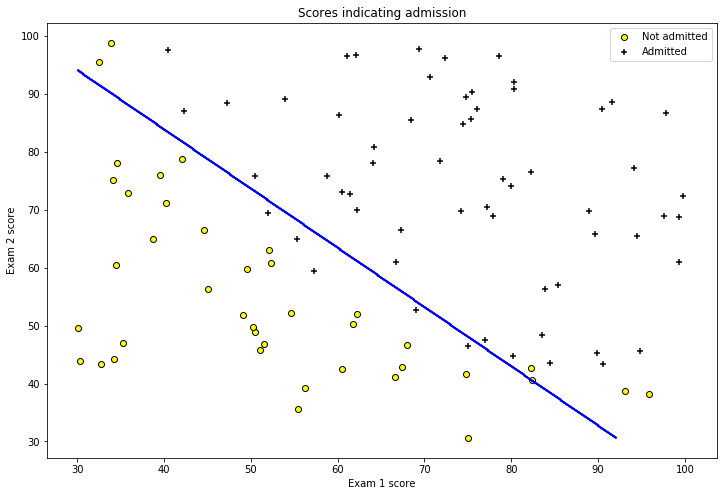

In [5]:
# Plotting the prediction line
col1 = "exam1"
col2 = "exam2"
min_ex1 = df[col1].min()
max_ex1 = df[col1].max()

min_ex2 = df[col2].min()
max_ex2 = df[col2].max()

arange_step = 0.1

xx, yy = np.meshgrid(np.arange(min_ex1, max_ex1, arange_step), 
                     np.arange(min_ex2, max_ex2, arange_step))
preds = np.c_[xx.ravel(), yy.ravel()]
preds = lr.predict(preds)
preds = preds.reshape(xx.shape)
fig = plt.figure(figsize = (12, 8))
plt.scatter(df[df['y'] == 0][col1], df[df['y'] == 0][col2],
            label = 'Not admitted', color = 'yellow', edgecolor = 'black')
plt.scatter(df[df['y'] == 1][col1], df[df['y'] == 1][col2],
            label = 'Admitted', marker = '+', color = 'black')
plt.contour(xx, yy, preds, colors = 'blue')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(loc = 'upper right')
plt.title('Scores indicating admission')
plt.show()